In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist = datasets.MNIST('./MNIST', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(mnist, batch_size=256, shuffle=True)

In [3]:
# Define o gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Entrada de 256 -> 128 com imagens 7*7
        self.fc1 = nn.Linear(256, 7*7*128)
        # A entrada de 128 é transformada em 64 com um aumento da imagem se tornando 14x14 (usado um kernel de 4x4)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        # A entrada de 64 é transformada em 1 com um aumento da imagem se tornando 28x28
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)
            #stride serve para aumentar a imagem
            #padding serve para aumentar a saida
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = x.view(-1, 128, 7, 7)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = torch.tanh(self.conv2(x))
        return x

In [4]:
# Define o discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(128*7*7, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(-1, 128*7*7)
        x = torch.sigmoid(self.fc1(x))
        return x

In [5]:
G = Generator()
D = Discriminator()

In [6]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)

In [7]:
# Defina a perda
loss = nn.BCELoss()

A: torch.Size([256, 1, 28, 28])
B: torch.Size([256, 1])


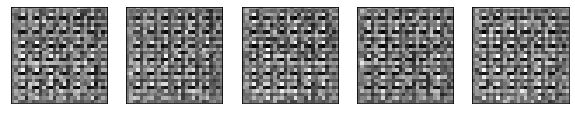

AttributeError: 'int' object has no attribute 'zero_grad'

In [11]:
for epoch in range(200):
    for i, (images, _) in enumerate(dataloader):
        # Update the discriminator
        D.zero_grad()
        # Número de amostras (10) não será mudada, depois os canais, e então altura e largura
        real_images = images.reshape(-1, 1, 28, 28)
        # Valor real = 1 (certo)
        real_labels = torch.ones(256, 1)
        real_outputs = D(real_images)
        real_loss = loss(real_outputs, real_labels)
        real_loss.backward()
        

        # Update the generator
        G.zero_grad()
        noise = torch.randn(256, 256)
        fake_images = G(noise)
        outputs = D(fake_images)
        print(f'A: {fake_images.shape}')
        print(f'B: {outputs.shape}')
        G_loss = loss(outputs, real_labels)
        G = 1
        G_loss.backward()
        G_optimizer.step()
        

        if i == 0:
            fig, ax = plt.subplots(1, 5, figsize=(10,5))
            for i in range(5):
                ax[i].imshow(fake_images.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
                ax[i].xaxis.set_visible(False)
                ax[i].yaxis.set_visible(False)
            plt.show()
            
        if (i + 1) % 100 == 0:
            fig, ax = plt.subplots(1, 5, figsize=(10,5))
            for i in range(5):
                ax[i].imshow(fake_images.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
                ax[i].xaxis.set_visible(False)
                ax[i].yaxis.set_visible(False)
            plt.show()
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, 200, i + 1, len(dataloader), real_loss + fake_loss, G_loss))
    print(epoch)